In [5]:
# basic imports
import json
import urllib.request

################################ Data mining from the FPL API ################################
# The only 2 parameters to specify are "teamID" and "lastGameweek"
teamID = 3446283
lastGameweek = 10

# Get the detailed info about a given FPL Manager’s Team and a given game week
gameweekData = {}
for i in range(1, lastGameweek + 1):
    base = "https://fantasy.premierleague.com/api/entry/" + str(teamID) + "/event/" + str(i) + "/picks/"
    page = urllib.request.urlopen(base)
    data = {"GW" + str(i) : json.load(page)}
    gameweekData.update(data)

# Get the general info about a given FPL Manager’s Team
base = "https://fantasy.premierleague.com/api/entry/" + str(teamID) + "/"
page = urllib.request.urlopen(base)
dataTeamInfo = json.load(page)

# Get the generic info about PL teams, the players and the game week details
base = "https://fantasy.premierleague.com/api/bootstrap-static/"
page = urllib.request.urlopen(base)
dataGeneral = json.load(page)
events = dataGeneral["events"]
elements = dataGeneral["elements"]

In [6]:
# Get the detailed info about a specific premier league player
def getPlayerPointsAtOneGW(playerID, gameweek):
    base = "https://fantasy.premierleague.com/api/element-summary/" + str(playerID) + "/"
    page = urllib.request.urlopen(base)
    datagw = json.load(page)
    gwPoints = 0
    for i in range(len(datagw["history"])):
        if gameweek == datagw["history"][i]["round"]: # to account for absent gameweek in the json
            gwPoints = gwPoints + datagw["history"][i]["total_points"] # to account for double gw
    return gwPoints

def getPlayerName(playerID):
    i = 0
    while i < len(elements):
        if (elements[i]["id"] == playerID):
            return (elements[i]["first_name"] + " " + elements[i]["second_name"])
        i += 1
    return "ID not found"

positions = ["GK", "DEF", "MID", "ST"]
def getPlayerPosition(playerID):
    i = 0
    while i < len(elements):
        if (elements[i]["id"] == playerID):
                playersElementType = elements[i]["element_type"]
                playerPosition = positions[playersElementType - 1]
                return playerPosition
        i += 1
    return "ID not found"

In [7]:
################################ Calculations ################################
# Get the specific team data from the json in organised lists and dictionaries
teamName = dataTeamInfo["name"]
points = []
gameweekRank = []
overallRank = []
teamValue = []
transfers = []
transfersCost = []
averagePoints = []
highestPoints = []
captain = []
captainPoints = []
startingTeam = {}
totalPointsPerLine = {}
totalPointsPerLineSeason = {"GK" : 0, "DEF" : 0, "MID" : 0, "ST" : 0}

for gw in range(1, lastGameweek + 1):
    # List with basic data each gw

    points.append(gameweekData["GW" + str(gw)]["entry_history"]["points"])
    gameweekRank.append(gameweekData["GW" + str(gw)]["entry_history"]["rank"])
    overallRank.append(gameweekData["GW" + str(gw)]["entry_history"]["overall_rank"])
    teamValue.append(gameweekData["GW" + str(gw)]["entry_history"]["value"])
    transfers.append(gameweekData["GW" + str(gw)]["entry_history"]["event_transfers"])
    transfersCost.append(gameweekData["GW" + str(gw)]["entry_history"]["event_transfers_cost"])
    averagePoints.append(events[gw-1]["average_entry_score"])
    highestPoints.append(events[gw-1]["highest_score"])

    # Dict with starting team each gw
    startingTeam["GW" + str(gw)] = {}
    for j in range(0, 15):
        if gameweekData["GW" + str(gw)]["picks"][j]["is_captain"] == True:
            captain.append(getPlayerName(gameweekData["GW" + str(gw)]["picks"][j]["element"]))
            captainPoints.append(getPlayerPointsAtOneGW(gameweekData["GW" + str(gw)]["picks"][j]["element"], gw))
    for n in range(0, 15):
        startingTeam["GW" + str(gw)]["player" + str(n)] = {}
        startingTeam["GW" + str(gw)]["player" + str(n)]["name"] = getPlayerName(gameweekData["GW" + str(gw)]["picks"][n]["element"])
        startingTeam["GW" + str(gw)]["player" + str(n)]["position"] = getPlayerPosition(gameweekData["GW" + str(gw)]["picks"][n]["element"])
        startingTeam["GW" + str(gw)]["player" + str(n)]["points"] = getPlayerPointsAtOneGW(gameweekData["GW" + str(gw)]["picks"][n]["element"], gw)

    # Dict with points per line each gw
    totalPointsPerLine["GW" + str(gw)] = {"GK" : 0, "DEF" : 0, "MID" : 0, "ST" : 0}
    for player in range(0, 11): # que les titulaires de 0 à 11 donc
        if startingTeam["GW" + str(gw)]["player" + str(player)]["position"] == "GK":
            totalPointsPerLine["GW" + str(gw)]["GK"] = totalPointsPerLine["GW" + str(gw)]["GK"] + startingTeam["GW" + str(gw)]["player" + str(player)]["points"]
        elif startingTeam["GW" + str(gw)]["player" + str(player)]["position"] == "DEF":
            totalPointsPerLine["GW" + str(gw)]["DEF"] = totalPointsPerLine["GW" + str(gw)]["DEF"] + startingTeam["GW" + str(gw)]["player" + str(player)]["points"]
        elif startingTeam["GW" + str(gw)]["player" + str(player)]["position"] == "MID":
            totalPointsPerLine["GW" + str(gw)]["MID"] = totalPointsPerLine["GW" + str(gw)]["MID"] + startingTeam["GW" + str(gw)]["player" + str(player)]["points"]
        elif startingTeam["GW" + str(gw)]["player" + str(player)]["position"] == "ST":
            totalPointsPerLine["GW" + str(gw)]["ST"] = totalPointsPerLine["GW" + str(gw)]["ST"] + startingTeam["GW" + str(gw)]["player" + str(player)]["points"]
    # Dict with points per line for the entire season
    totalPointsPerLineSeason["GK"] = totalPointsPerLineSeason["GK"] + totalPointsPerLine["GW" + str(gw)]["GK"]
    totalPointsPerLineSeason["DEF"] = totalPointsPerLineSeason["DEF"] + totalPointsPerLine["GW" + str(gw)]["DEF"]
    totalPointsPerLineSeason["MID"] = totalPointsPerLineSeason["MID"] + totalPointsPerLine["GW" + str(gw)]["MID"]
    totalPointsPerLineSeason["ST"] = totalPointsPerLineSeason["ST"] + totalPointsPerLine["GW" + str(gw)]["ST"]

    print("GW" + str(gw) + " : Done.")


GW1 : Done.
GW2 : Done.
GW3 : Done.
GW4 : Done.
GW5 : Done.
GW6 : Done.
GW7 : Done.
GW8 : Done.
GW9 : Done.
GW10 : Done.


In [20]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Creating a subplot figure with 3 rows and 2 columns, specifying the type for the pie chart
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=("Team points", "Team rank", "Team value", "Team transfers", "Captain points", "Points per position"),
    specs=[[{}, {}], [{}, {}], [{}, {"type": "domain"}]]  # Specify the type for pie chart
)

gameweek = list(range(1, lastGameweek + 1))

### Team points
fig.add_trace(
    go.Scatter(x=gameweek, y=points, mode='lines', name='Team FPL points'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=gameweek, y=averagePoints, mode='lines', name='Average FPL points'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=gameweek, y=highestPoints, mode='lines', name='Highest FPL points'),
    row=1, col=1
)

### Team rank
fig.add_trace(
    go.Bar(x=gameweek, y=gameweekRank, name='GW Rank'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=gameweek, y=overallRank, mode='lines', name='Overall rank'),
    row=1, col=2
)

### Team value
fig.add_trace(
    go.Bar(x=gameweek, y=list(map(lambda x: x/10, teamValue)), name='Team Value (incl. bank)'),
    row=2, col=1
)

### Team transfers
fig.add_trace(
    go.Bar(x=gameweek, y=transfers, name='Number of transfers'),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=gameweek, y=transfersCost, mode='lines+markers', name='Transfers cost', yaxis='y2'),
    row=2, col=2
)

### Captain points
fig.add_trace(
    go.Bar(x=gameweek, y=list(map(lambda x: x*2, captainPoints)), name='Captain FPL points'),
    row=3, col=1
)

### Points per position
fig.add_trace(
    go.Pie(labels=list(totalPointsPerLineSeason.keys()),
           values=list(totalPointsPerLineSeason.values()),
           name='Points per position'),
    row=3, col=2
)

# Update layout for pie chart legend and colors
fig.update_traces(marker=dict(colors=['#FFEBCD', '#030303', '#FF4040', '#CAFF70']), row=3, col=2)

# Set y-axis titles
fig.update_yaxes(title_text="FPL points", row=1, col=1)
fig.update_yaxes(title_text="Rank", row=1, col=2)
fig.update_yaxes(title_text="Value (£)", row=2, col=1)
fig.update_yaxes(title_text="Number of transfers", row=2, col=2)
fig.update_yaxes(title_text="Transfers cost", secondary_y=True, row=2, col=2)
fig.update_yaxes(title_text="Captain FPL points (x2)", row=3, col=1)

# Set x-axis titles
fig.update_xaxes(title_text="Gameweek", row=3, col=1)

# Update layout for the entire figure
fig.update_layout(
    title="Team performance: " + teamName,
    showlegend=True,
    height=800  # Adjust the height if needed for better layout
)

# Show figure
fig.show()

Text(0.5, 0, 'Points per position over the season')

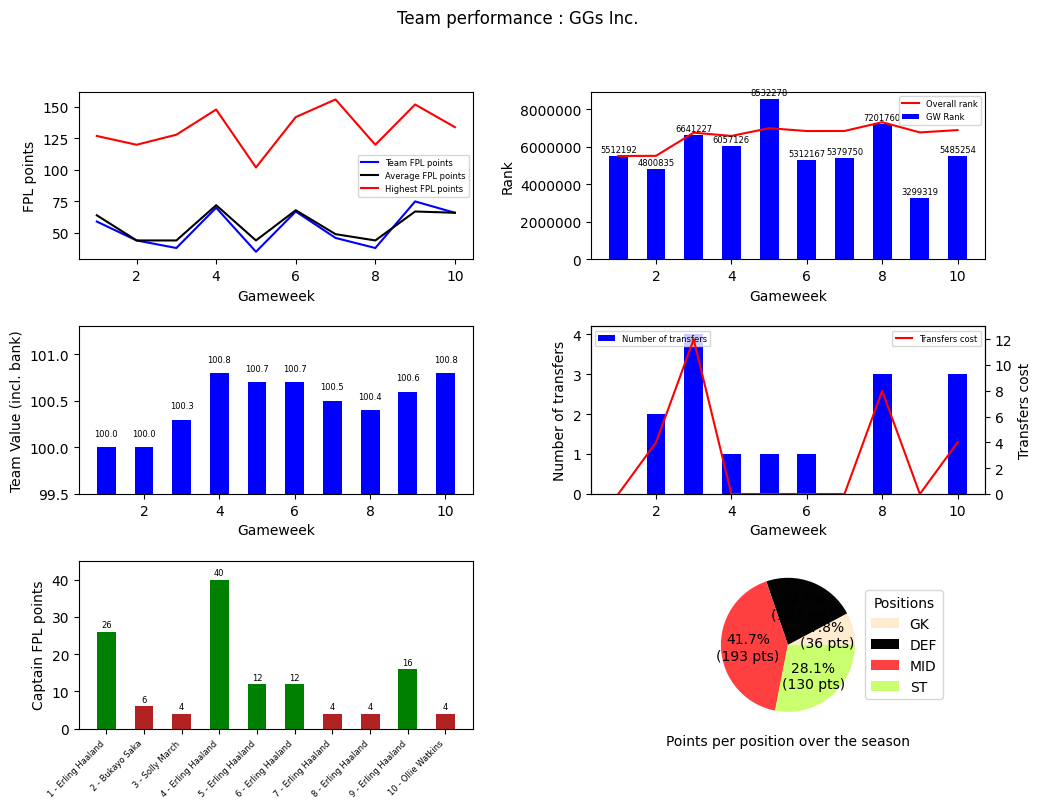

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

gameweek = np.arange(1, lastGameweek+1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(11.69, 8.27)) #fig size A4 in inches figsize=(11.69,8.27)
fig.suptitle("Team performance : " + teamName)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)


### Team points
ax1.plot(gameweek, points, color='b', label='Team FPL points')
ax1.plot(gameweek, averagePoints, color='black', label='Average FPL points')
ax1.plot(gameweek, highestPoints, color='r', label='Highest FPL points')
ax1.set_xlabel('Gameweek')
ax1.set_ylabel('FPL points')
ax1.legend(loc='best', frameon=True, prop={'size':6})


### Team rank
gameweekRank = np.array(gameweekRank)
ax2.bar(gameweek, gameweekRank, color='b', label='GW Rank', width=0.5)
ax2.plot(gameweek, overallRank, color='r', label='Overall rank')
ax2.set_ylim(ymin=0)
ax2.set_ylim(ymax=max(gameweekRank + 400000))
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.set_xlabel('Gameweek')
ax2.set_ylabel('Rank')
ax2.legend(loc='best', frameon=True, prop={'size':6})
rects = ax2.patches
for rect in rects:
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 100000, height, ha='center', va='bottom', size=6)


### Team value
ax3.bar(gameweek, list(map(lambda x: x/10, teamValue)), width=0.5, color='b')
ax3.set_ylim(ymin=min(list(map(lambda x: x/10, teamValue)))-0.5)
ax3.set_ylim(ymax=max(list(map(lambda x: x/10, teamValue)))+0.5)
ax3.set_xlabel('Gameweek')
ax3.set_ylabel('Team Value (incl. bank)')
rects = ax3.patches
labels = [sum(x) for x in zip(list(map(lambda x: round(x/10, 1), teamValue)))]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax3.text(rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha='center', va='bottom', size=6)


### Team transfers
ax44 = ax4.twinx()
ax4.bar(gameweek, transfers, color='b', label='Number of transfers', width=0.5)
ax44.plot(gameweek, transfersCost, color='r', label='Transfers cost')
ax4.set_xlabel('Gameweek')
ax4.set_ylabel('Number of transfers')
ax44.set_ylabel('Transfers cost')
ax4.legend(loc=2, frameon=True, prop={'size':6})
ax44.legend(loc=1, frameon=True, prop={'size':6})
ax44.set_ylim(ymin=0)
ax44.set_ylim(ymax=max(transfersCost)+1)
ax4.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax44.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


### Captain points
captainPoints = np.array(captainPoints)
captainDisplay = []
for n in range(0, lastGameweek):
    captainDisplay.append(str(n+1) + " - " + captain[n])
mask1 = captainPoints > 3
mask2 = captainPoints <= 3
ax5.bar(gameweek[mask1], list(map(lambda x: x*2, captainPoints[mask1])), width=0.5, color='green')
ax5.bar(gameweek[mask2], list(map(lambda x: x*2, captainPoints[mask2])), width=0.5, color='firebrick')
ax5.set_ylim(ymin=0)
ax5.set_ylim(ymax=max(list(map(lambda x: x*2, captainPoints)))+5)
ax5.set_xticks(gameweek)
ax5.set_xticklabels(captainDisplay, rotation=45, ha="right", size=6)
ax5.set_ylabel('Captain FPL points')
rects = ax5.patches
for rect in rects:
    height = rect.get_height()
    ax5.text(rect.get_x() + rect.get_width() / 2, height + 0.6, height, ha='center', va='bottom', size=6)


### Points per position
positions = list(totalPointsPerLineSeason.keys())
pointsPos = list(totalPointsPerLineSeason.values())
colors = ['#FFEBCD', '#030303', '#FF4040', '#CAFF70']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} pts)".format(pct, absolute)

wedges, texts, autotexts = ax6.pie(pointsPos, autopct=lambda pct: func(pct, pointsPos),
                                   textprops=dict(color="k"), colors=colors)

ax6.legend(wedges, positions,
           title="Positions",
           loc="center left",
           bbox_to_anchor=(0.92, 0, 0.5, 1))

ax6.set_xlabel("Points per position over the season")